# Applied Machine Learning

## Exploratory Data Analysis

In this notebook, we will go over the data for our project to obtain more insights about the distribution, features and classes for *Sleep EDF Database*. This EDA uses the **sleep stage annotations** found in the `-Hypnogram.edf` files. The analysis of features relevant to **arousal detection** requires the feature engineering step outlined in the project plan and the definitive arousal labels.

In [13]:
import mne
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import sys
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [ ]:
module_path = os.path.abspath(os.path.join('..', 'src', 'utils'))
if module_path not in sys.path:
    sys.path.append(module_path)

try:
    from src.utils.load_data import load_sleep_data
except ImportError as e:
    print(f"Error importing load_data: {e}")
    print(f"Please ensure 'load_data.py' is in the directory: {module_path}")
    def load_sleep_data(*args, **kwargs):
        print("Warning: load_sleep_data could not be imported. Returning empty list.")
        return

In [15]:
DATA_DIR = './data'
MAX_SUBJECTS = 3
EPOCH_DURATION = 30
PRELOAD = True
EVENT_ID_MAPPING = {
    'Sleep stage W': 1, 'Sleep stage 1': 2, 'Sleep stage 2': 3,
    'Sleep stage 3': 4, 'Sleep stage 4': 4,
    'Sleep stage R': 5, 'Sleep stage ?': 6, 'Movement time': 6
}
ID_EVENT_MAPPING = {v: k for k, v in EVENT_ID_MAPPING.items()}
ID_EVENT_MAPPING[4] = 'Sleep stage 3/4'
ID_EVENT_MAPPING[6] = 'Unknown/Movement'
EXPECTED_CHANNELS = ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker']
RELEVANT_CHANNELS = ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'EMG submental']

raw_list = load_sleep_data(data_dir=DATA_DIR,
                           max_subjects=MAX_SUBJECTS,
                           preload_data=PRELOAD)

if not raw_list:
    print(f"No data loaded. Please check the DATA_DIR ('{DATA_DIR}') and ensure the Physionet data is downloaded and extracted correctly.")
    print("Expected subdirectories: 'sleep-cassette' and/or 'sleep-telemetry'.")
    raise SystemExit("Stopping notebook execution due to missing data.")
else:
    print(f"\nSuccessfully loaded data for {len(raw_list)} subjects.")

/Users/mede/Applied-ML/project_name/utils/load_data.py:135: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations, emit_warning=True)
/Users/mede/Applied-ML/project_name/utils/load_data.py:135: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations, emit_warning=True)



Successfully loaded data for 3 subjects.


/Users/mede/Applied-ML/project_name/utils/load_data.py:135: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations, emit_warning=True)


In [17]:
if raw_list:
    raw_example = raw_list[0]
    info = raw_example.info
    subject_id = info.get('subject_info', {}).get('id', 'Unknown')
    print(f"--- Information for Subject: {subject_id} ---")
    print(f"Channels ({len(info['ch_names'])}): {info['ch_names']}")
    print(f"Sampling Frequency (sfreq): {info['sfreq']} Hz")
    duration_sec = raw_example.n_times / info['sfreq']
    print(f"Recording Duration: {duration_sec:.2f} seconds ({duration_sec/3600:.2f} hours)")

    # Get annotations (sleep stages)
    annotations = raw_example.annotations
    print(f"Number of annotations (events): {len(annotations)}")
    print(f"Annotation descriptions found: {np.unique(annotations.description)}")

    # Verify available channels against expected relevant channels
    print("\nChecking relevant channels for SVM:")
    available_channels = info['ch_names']
    missing_channels = [ch for ch in RELEVANT_CHANNELS if ch not in available_channels]
    if not missing_channels:
        print("All relevant channels for SVM are present.")
    else:
        print(f"Warning: The following relevant channels are missing: {missing_channels}")
        # Update RELEVANT_CHANNELS_FOR_SVM to only include available ones for subsequent analysis
        RELEVANT_CHANNELS = [ch for ch in RELEVANT_CHANNELS if ch in available_channels]
        print(f"Using available relevant channels: {RELEVANT_CHANNELS}")

--- Information for Subject: SC4001E0 ---
Channels (7): ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker']
Sampling Frequency (sfreq): 100.0 Hz
Recording Duration: 79500.00 seconds (22.08 hours)
Number of annotations (events): 154
Annotation descriptions found: ['Sleep stage 1' 'Sleep stage 2' 'Sleep stage 3' 'Sleep stage 4'
 'Sleep stage ?' 'Sleep stage R' 'Sleep stage W']

Checking relevant channels for SVM:
All relevant channels for SVM are present.


In [20]:
all_epochs_list = []
all_labels_list = []
all_subject_ids = []

for i, raw in enumerate(raw_list):
    subject_id = raw.info.get('subject_info', {}).get('id', f'Unknown_{i}')
    print(f"\nProcessing Subject: {subject_id}")
    sfreq = raw.info['sfreq']

    try:
        events, event_id_map_used = mne.events_from_annotations(raw, event_id=EVENT_ID_MAPPING, chunk_duration=EPOCH_DURATION)
        print(f"Extracted {len(events)} epochs/events.")

        channels_present = raw.info['ch_names']
        picks_final = [ch for ch in RELEVANT_CHANNELS if ch in channels_present]
        if not picks_final:
             print(f"Warning: No relevant SVM channels found for subject {subject_id}. Skipping.")
             continue

        print(f"Using channels: {picks_final}")

        baseline = None

        epochs = mne.Epochs(raw, events, event_id=EVENT_ID_MAPPING,
                            tmin=0., tmax=EPOCH_DURATION - 1./sfreq,
                            proj=False, picks=picks_final,
                            baseline=baseline, preload=True,
                            event_repeated='drop',
                            on_missing='warn')

        print(f"Created {len(epochs)} epochs of duration {EPOCH_DURATION}s.")
        all_epochs_list.append(epochs)
        all_labels_list.extend(epochs.events[:, 2])
        all_subject_ids.extend([subject_id] * len(epochs))

    except ValueError as ve:
        print(f"ValueError processing subject {subject_id}: {ve}")
        print("This might happen if events are too close to the start/end of the recording.")
        import traceback
        traceback.print_exc()
    except Exception as e:
        print(f"Error processing subject {subject_id}: {e}")
        import traceback
        traceback.print_exc()

all_labels = np.array(all_labels_list)

if not all_epochs_list:
    print("\nWarning: No epochs were successfully created for any subject.")
else:
    print(f"\nSuccessfully created epochs for {len(all_epochs_list)} subjects.")


Processing Subject: SC4001E0
Extracted 2650 epochs/events.
Using channels: ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'EMG submental']


/var/folders/66/090nps5x40dbrrnzfg1js3mm0000gn/T/ipykernel_15244/263380272.py:24: RuntimeWarning: No matching events found for Sleep stage ? (event id 6)
  epochs = mne.Epochs(raw, events, event_id=EVENT_ID_MAPPING,
/var/folders/66/090nps5x40dbrrnzfg1js3mm0000gn/T/ipykernel_15244/263380272.py:24: RuntimeWarning: No matching events found for Movement time (event id 6)
  epochs = mne.Epochs(raw, events, event_id=EVENT_ID_MAPPING,


Created 2650 epochs of duration 30s.

Processing Subject: SC4002E0
Extracted 2830 epochs/events.
Using channels: ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'EMG submental']
Created 2830 epochs of duration 30s.

Processing Subject: SC4011E0
Extracted 2802 epochs/events.
Using channels: ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'EMG submental']


/var/folders/66/090nps5x40dbrrnzfg1js3mm0000gn/T/ipykernel_15244/263380272.py:24: RuntimeWarning: No matching events found for Sleep stage ? (event id 6)
  epochs = mne.Epochs(raw, events, event_id=EVENT_ID_MAPPING,
/var/folders/66/090nps5x40dbrrnzfg1js3mm0000gn/T/ipykernel_15244/263380272.py:24: RuntimeWarning: No matching events found for Movement time (event id 6)
  epochs = mne.Epochs(raw, events, event_id=EVENT_ID_MAPPING,


Created 2802 epochs of duration 30s.

Successfully created epochs for 3 subjects.


## Class Distribution Plot

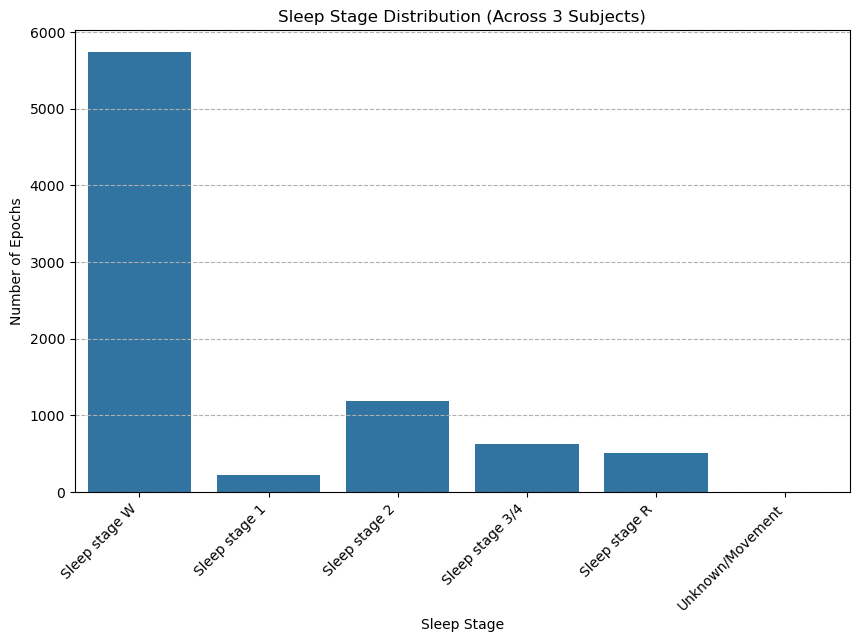

In [ ]:
if len(all_labels) > 0:
    label_counts = Counter(all_labels)
    labels_str = [ID_EVENT_MAPPING.get(l, f'Unknown ({l})') for l in label_counts.keys()]
    counts = list(label_counts.values())

    sorted_indices = np.argsort(list(label_counts.keys()))
    labels_str_sorted = [labels_str[i] for i in sorted_indices]
    counts_sorted = [counts[i] for i in sorted_indices]

    plt.figure(figsize=(10, 6))
    sns.barplot(x=labels_str_sorted, y=counts_sorted)
    plt.title(f'Sleep Stage Distribution (Across {len(all_epochs_list)} Subjects)')
    plt.xlabel('Sleep Stage')
    plt.ylabel('Number of Epochs')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--')
    plt.show()

else:
    print("No labels extracted, skipping distribution plot.")

## Signal Visualization


Plotting example epochs for channels: ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'EMG submental']


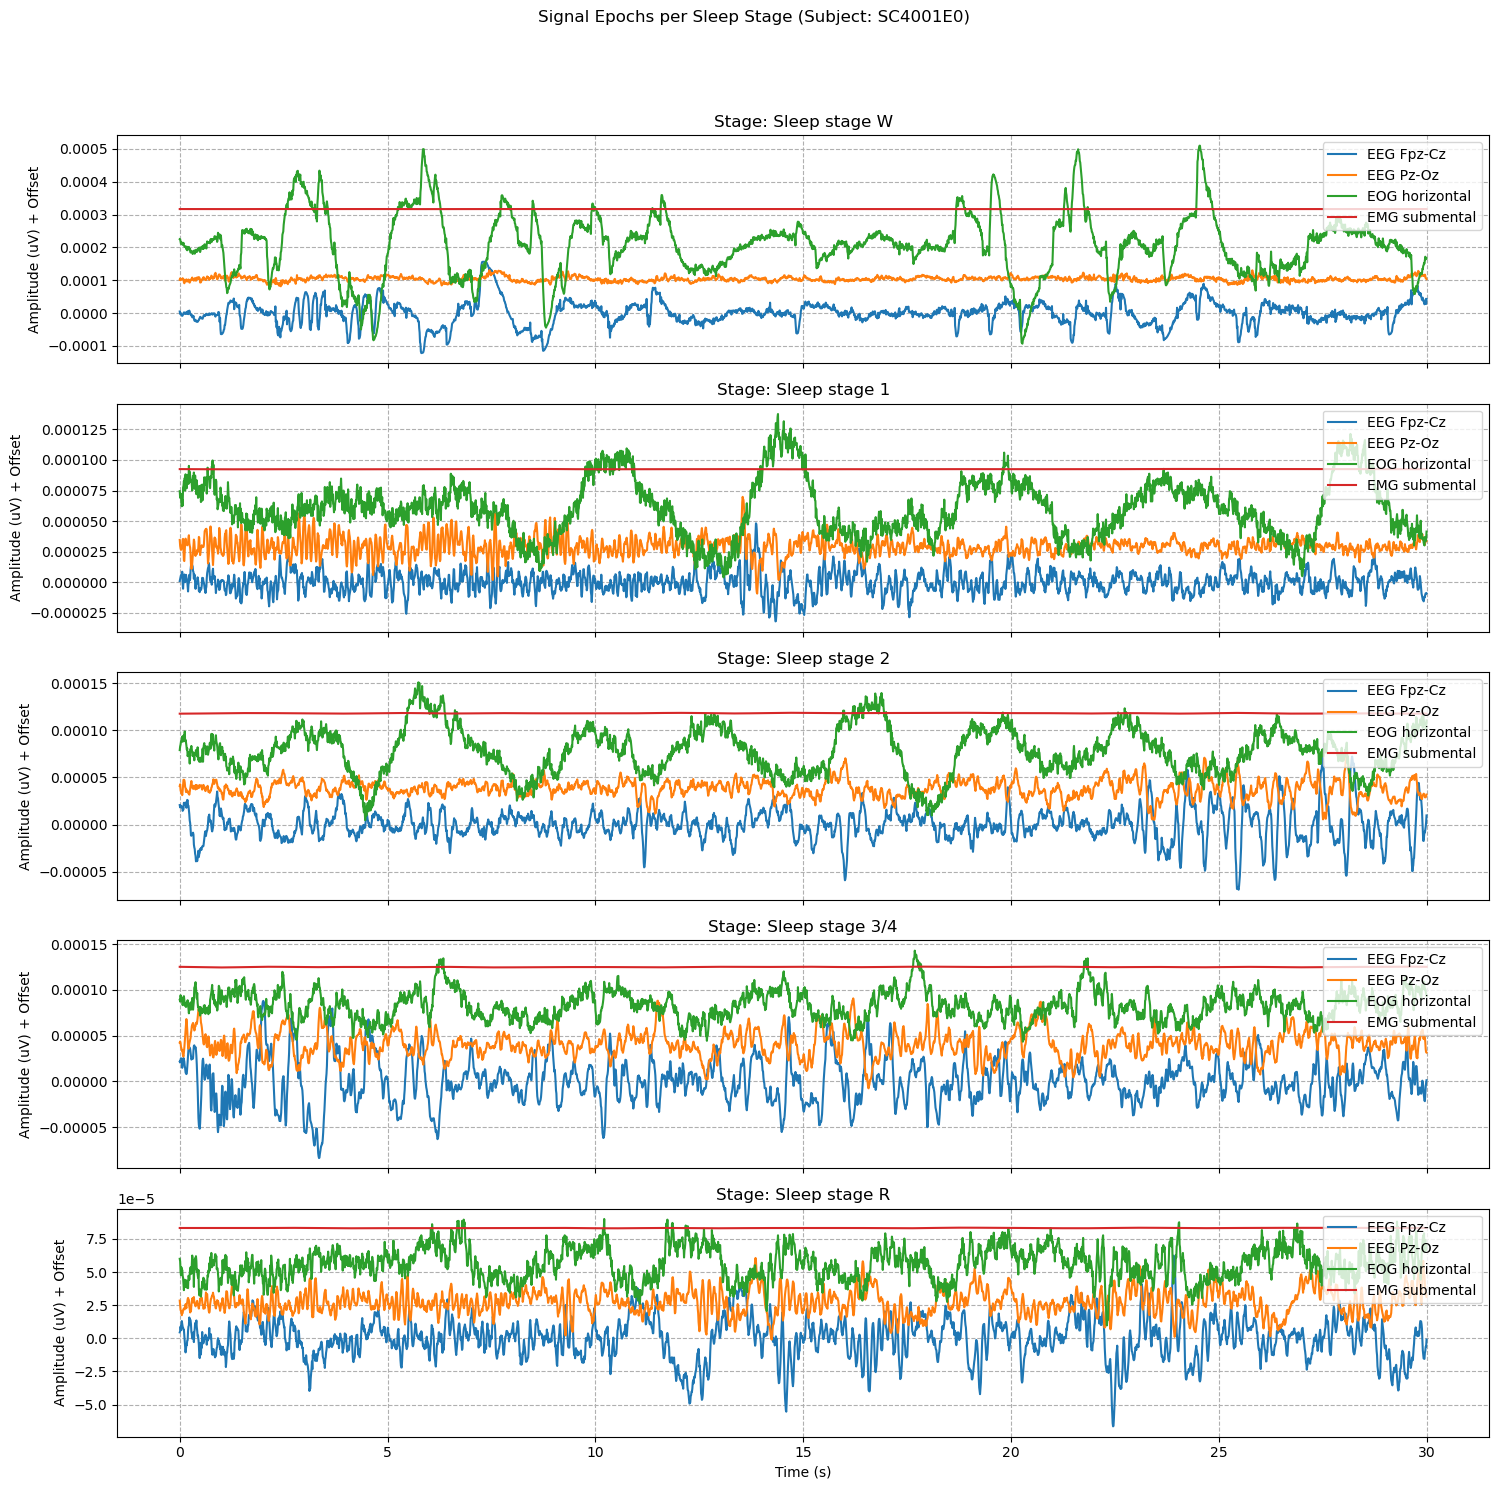

In [24]:
if all_epochs_list:
    epochs_example = all_epochs_list[0]
    labels_example = epochs_example.events[:, 2]
    subject_id = epochs_example.info.get('subject_info', {}).get('id', 'Unknown')

    stages_to_plot = sorted(np.unique(labels_example))

    plot_channels = [ch for ch in RELEVANT_CHANNELS if ch in epochs_example.ch_names]
    if not plot_channels:
        print("No relevant channels found in epochs object for plotting signals.")
    else:
        print(f"\nPlotting example epochs for channels: {plot_channels}")

        n_epochs_per_stage = 2

        fig, axes = plt.subplots(len(stages_to_plot), 1, figsize=(15, 3 * len(stages_to_plot)), sharex=True)
        if len(stages_to_plot) == 1: axes = [axes]

        for i, stage_id in enumerate(stages_to_plot):
            stage_name = ID_EVENT_MAPPING.get(stage_id, f'Unknown ({stage_id})')
            stage_indices = np.where(labels_example == stage_id)[0]

            if len(stage_indices) > 0:
                epochs_to_show_indices = stage_indices[:n_epochs_per_stage]
                data, times = epochs_example[epochs_to_show_indices].get_data(picks=plot_channels)
                data_concat = data.reshape(len(plot_channels), -1)
                times_concat = np.arange(data_concat.shape[1]) / epochs_example.info['sfreq']

                ax = axes[i]
                offset = np.mean(np.std(data_concat, axis=1)) * 3
                for ch_idx, ch_name in enumerate(plot_channels):
                    ax.plot(times_concat, data_concat[ch_idx, :] + ch_idx * offset, label=ch_name)

                ax.set_title(f"Stage: {stage_name}")
                ax.set_ylabel("Amplitude (uV) + Offset")
                ax.legend(loc='upper right')
                ax.grid(True, linestyle='--')
                if i == len(stages_to_plot) - 1:
                    ax.set_xlabel("Time (s)")
            else:
                axes[i].set_title(f"Stage: {stage_name} - No epochs found")
                axes[i].axis('off')

        plt.suptitle(f'Signal Epochs per Sleep Stage (Subject: {subject_id})', y=1.02)
        plt.tight_layout(rect=[0, 0.03, 1, 0.98])
        plt.show()

else:
    print("No epochs data available to plot signals.")

## Feature Distribution

/var/folders/66/090nps5x40dbrrnzfg1js3mm0000gn/T/ipykernel_15244/1896966686.py:4: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_epochs_concatenated = mne.concatenate_epochs(all_epochs_list)



Data shape for amplitude analysis: (8282, 4, 3000)


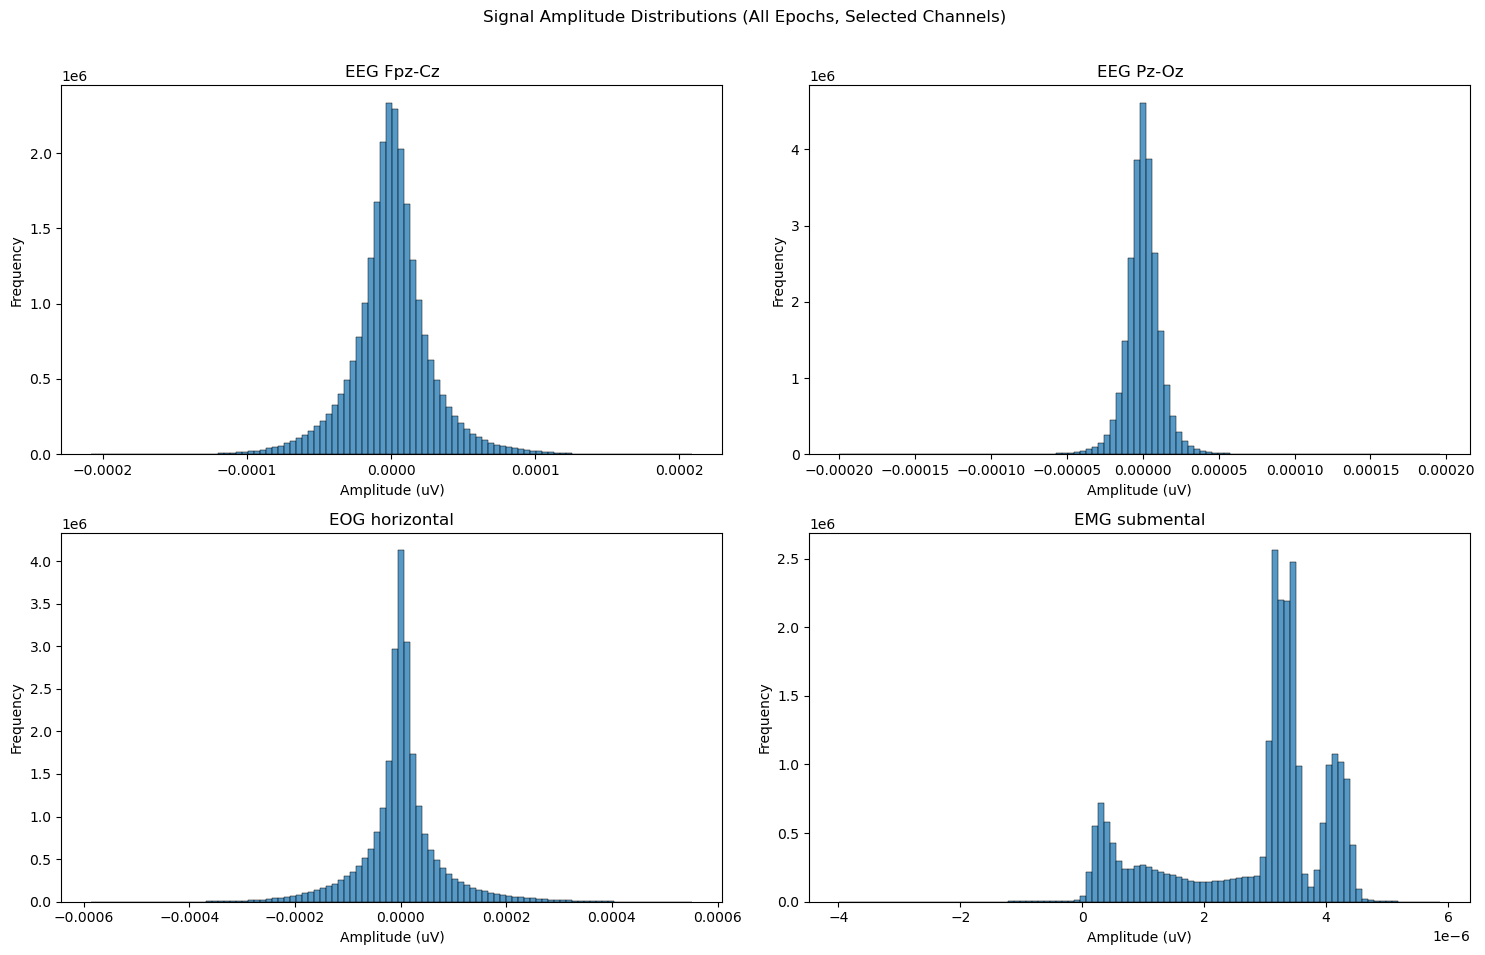

In [ ]:
if all_epochs_list:
    all_data_list = []
    all_epochs_concatenated = mne.concatenate_epochs(all_epochs_list)

    channels_to_get = [ch for ch in RELEVANT_CHANNELS if ch in all_epochs_concatenated.ch_names]

    if channels_to_get:
        all_data = all_epochs_concatenated.get_data(picks=channels_to_get)
        n_epochs, n_channels, n_times = all_data.shape
        print(f"\nData shape for amplitude analysis: {all_data.shape}")

        all_data_reshaped = all_data.transpose(1, 0, 2).reshape(n_channels, -1)

        plt.figure(figsize=(15, 5 * n_channels // 2))
        plt.suptitle('Signal Amplitude Distributions (All Epochs, Selected Channels)')
        for i, ch_name in enumerate(channels_to_get):
            plt.subplot(n_channels // 2 + n_channels % 2, 2, i + 1)
            sns.histplot(all_data_reshaped[i, :], bins=100, kde=False)
            plt.title(ch_name)
            plt.xlabel('Amplitude (uV)')
            plt.ylabel('Frequency')

        plt.tight_layout(rect=[0, 0.03, 1, 0.97])
        plt.show()

    else:
        print("No relevant channels found in concatenated epochs for amplitude distribution analysis.")
else:
    print("No epochs data available for amplitude distribution analysis.")

## PSD Plots

Concatenating epochs (Annotation warning is expected)...


/var/folders/66/090nps5x40dbrrnzfg1js3mm0000gn/T/ipykernel_15244/4285280718.py:5: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs_psd = mne.concatenate_epochs(all_epochs_list)


Epochs concatenated.

Using channel: EEG Fpz-Cz with sfreq: 100.0 Hz
Processing stage: Sleep stage W...
  Extracted data shape for stage Sleep stage W: (5738, 1, 3000)
  Successfully plotted stage: Sleep stage W
Processing stage: Sleep stage 1...
  Extracted data shape for stage Sleep stage 1: (226, 1, 3000)
  Successfully plotted stage: Sleep stage 1
Processing stage: Sleep stage 2...
  Extracted data shape for stage Sleep stage 2: (1185, 1, 3000)
  Successfully plotted stage: Sleep stage 2
Processing stage: Sleep stage 3/4...
  Extracted data shape for stage Sleep stage 3/4: (622, 1, 3000)
  Successfully plotted stage: Sleep stage 3/4
Processing stage: Sleep stage R...
  Extracted data shape for stage Sleep stage R: (510, 1, 3000)
  Successfully plotted stage: Sleep stage R


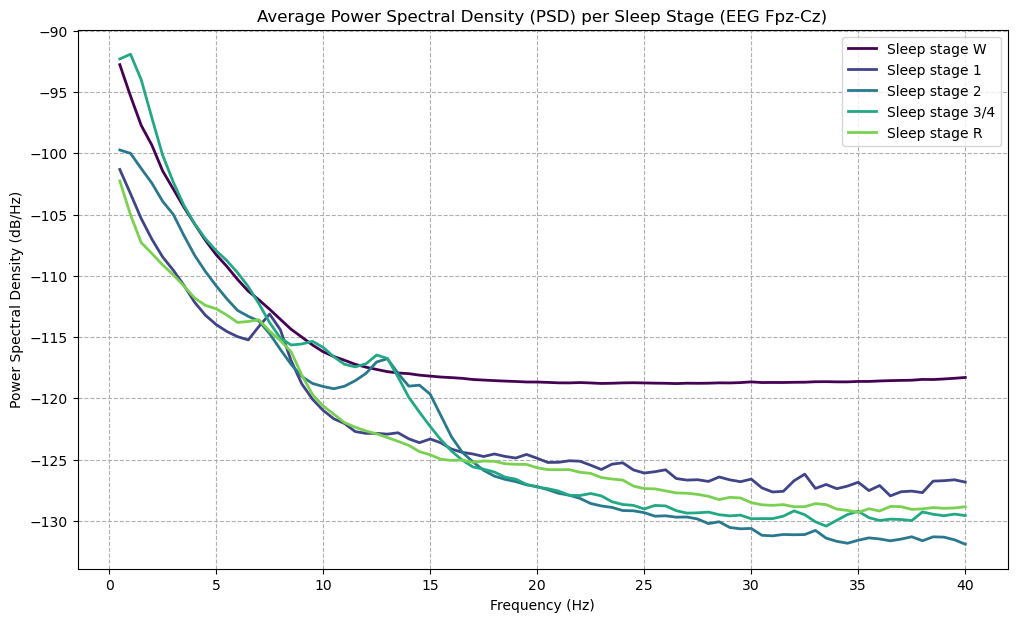

In [38]:
from mne.time_frequency import psd_array_welch

if all_epochs_list:
    print("Concatenating epochs (Annotation warning is expected)...")
    epochs_psd = mne.concatenate_epochs(all_epochs_list)
    labels_psd = epochs_psd.events[:, 2]
    print("Epochs concatenated.")

    eeg_channels = mne.pick_types(epochs_psd.info, meg=False, eeg=True)
    if len(eeg_channels) > 0:
        psd_pick_idx = eeg_channels[0]
        picks_for_psd = [psd_pick_idx]
        psd_pick_name = epochs_psd.ch_names[psd_pick_idx]
        sfreq = epochs_psd.info['sfreq']
        print(f"\nUsing channel: {psd_pick_name} with sfreq: {sfreq} Hz")

        plt.figure(figsize=(12, 7))
        ax = plt.subplot(111)
        stages_present = sorted(np.unique(labels_psd))
        colors = plt.cm.viridis(np.linspace(0, 1, len(stages_present)))

        for i, stage_id in enumerate(stages_present):
            stage_name = ID_EVENT_MAPPING.get(stage_id, f'Unknown ({stage_id})')
            if stage_id == 6: continue

            print(f"Processing stage: {stage_name}...")
            stage_indices = np.where(labels_psd == stage_id)[0]

            if len(stage_indices) > 0:
                try:
                    data_subset = epochs_psd[stage_indices].get_data(picks=picks_for_psd)
                    print(f"  Extracted data shape for stage {stage_name}: {data_subset.shape}")

                    psds_list = []
                    freqs = None
                    n_fft = int(2 * sfreq)
                    n_overlap = int(1 * sfreq)

                    for epoch_data in data_subset:
                        psds_epoch, freqs_epoch = psd_array_welch(
                            epoch_data, sfreq=sfreq, fmin=0.5, fmax=40.0,
                            n_fft=n_fft, n_overlap=n_overlap, verbose=False,
                            average='mean'
                        )
                        psds_list.append(psds_epoch)
                        if freqs is None:
                            freqs = freqs_epoch

                    if psds_list:
                        psds_array = np.stack(psds_list, axis=0)
                        psds_mean = np.mean(psds_array, axis=0)
                        psds_mean_channel = psds_mean[0, :]

                        # Plot the result in dB
                        ax.plot(freqs, 10 * np.log10(psds_mean_channel), label=stage_name, color=colors[i], lw=2)
                        print(f"  Successfully plotted stage: {stage_name}")
                    else:
                         print(f"  No PSDs generated for stage: {stage_name}")


                except Exception as e:
                    print(f"  Error processing stage {stage_name}: {e}")
                    import traceback
                    traceback.print_exc()
            else:
                 print(f"  Skipping stage {stage_name} - No epochs found.")

        ax.set_title(f'Average Power Spectral Density (PSD) per Sleep Stage ({psd_pick_name})')
        ax.set_xlabel('Frequency (Hz)')
        ax.set_ylabel('Power Spectral Density (dB/Hz)')
        handles, labels = ax.get_legend_handles_labels()
        if handles:
            ax.legend(handles, labels, loc='upper right')
        ax.grid(True, linestyle='--')
        plt.show()

    else:
        print("No EEG channels found for PSD analysis.")

else:
    print("No epochs data available for PSD analysis.")

## Correlation

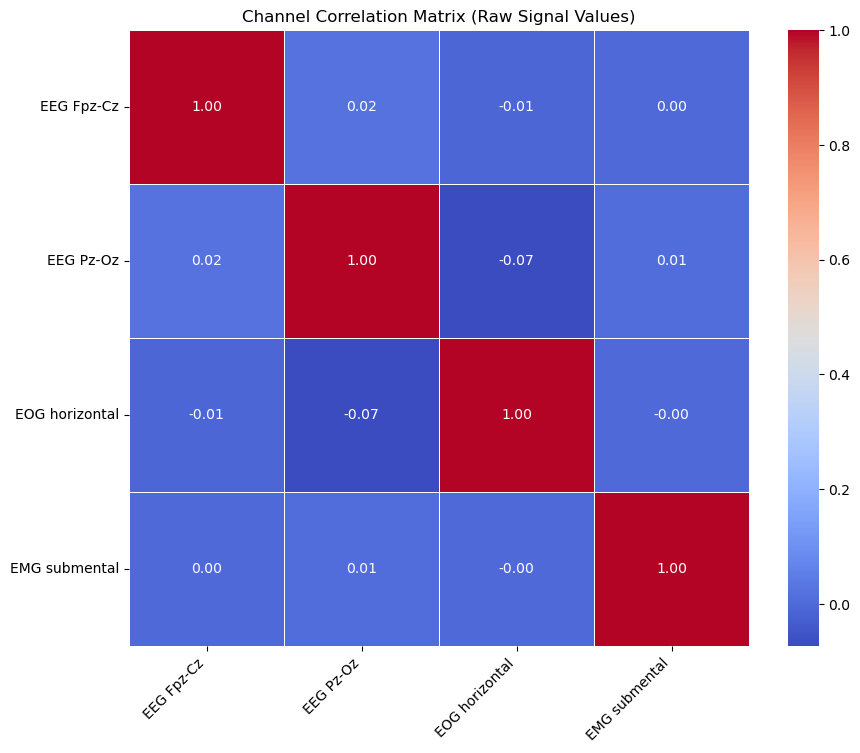

In [30]:
if all_epochs_list:
    # Use the concatenated epochs data again
    channels_corr = [ch for ch in RELEVANT_CHANNELS + ['Resp oro-nasal', 'Temp rectal'] if ch in all_epochs_concatenated.ch_names] # Include a few others if present
    if len(channels_corr) > 1:
        data_corr = all_epochs_concatenated.get_data(picks=channels_corr) # (n_epochs, n_channels, n_times)
        n_epochs_corr, n_channels_corr, n_times_corr = data_corr.shape

        # Reshape to (n_epochs * n_times, n_channels)
        data_corr_reshaped = data_corr.transpose(0, 2, 1).reshape(-1, n_channels_corr)

        # Create a pandas DataFrame for easier correlation calculation and plotting
        df_corr = pd.DataFrame(data_corr_reshaped, columns=channels_corr)

        # Calculate the correlation matrix
        correlation_matrix = df_corr.corr()

        # Plot the heatmap
        plt.figure(figsize=(10, 8))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
        plt.title('Channel Correlation Matrix (Raw Signal Values)')
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.show()

    else:
        print("Not enough relevant channels found in concatenated epochs for correlation analysis.")

else:
    print("No epochs data available for correlation analysis.")

## Dimensionality Reduction Plots

/var/folders/66/090nps5x40dbrrnzfg1js3mm0000gn/T/ipykernel_15244/309721872.py:2: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs_dr = mne.concatenate_epochs(all_epochs_list)



Extracting features from 8282 epochs, 4 channels (['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'EMG submental']) for DR...
Feature matrix shape: (8282, 8)
Features scaled using StandardScaler.

Applying PCA...
Explained variance ratio (first 2 components): [0.27476626 0.21469691]
Total explained variance: 0.489

Subsampling data to 5000 points for t-SNE...

Applying t-SNE (this may take a while)...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.001s...
[t-SNE] Computed neighbors for 5000 samples in 0.160s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000


/Users/mede/anaconda3/envs/AML/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.469729
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.565018
[t-SNE] KL divergence after 300 iterations: 2.300545


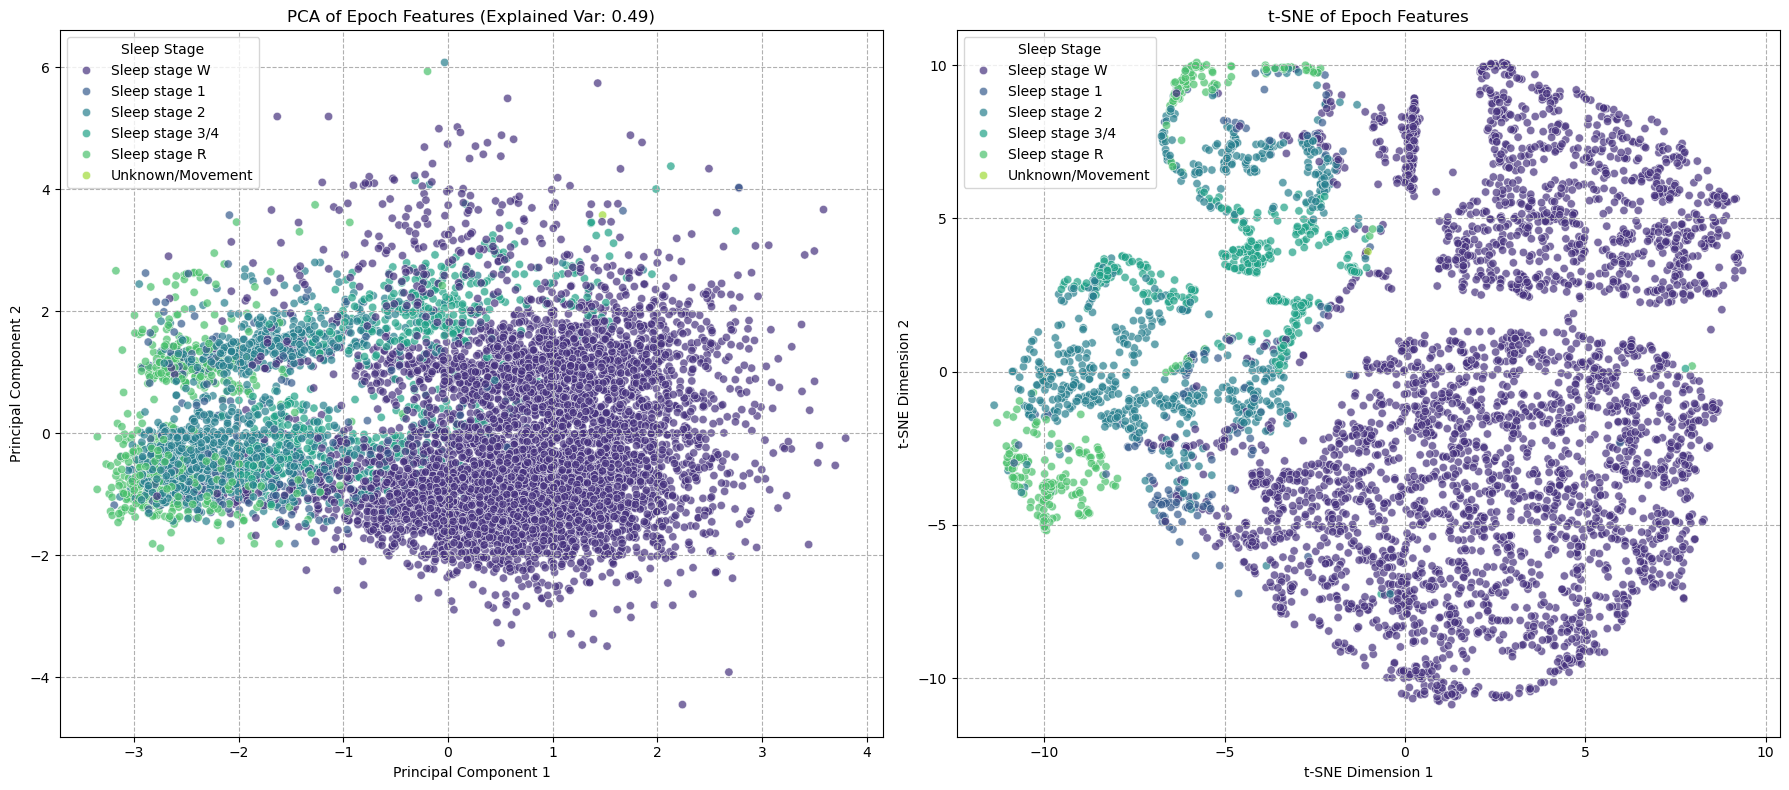

In [33]:
if all_epochs_list:
    epochs_dr = mne.concatenate_epochs(all_epochs_list)
    labels_dr = epochs_dr.events[:, 2]
    channels_dr = [ch for ch in RELEVANT_CHANNELS if ch in epochs_dr.ch_names]

    if channels_dr:
        data_dr = epochs_dr.get_data(picks=channels_dr) # (n_epochs, n_channels, n_times)
        n_epochs_dr, n_channels_dr, n_times_dr = data_dr.shape
        print(f"\nExtracting features from {n_epochs_dr} epochs, {n_channels_dr} channels ({channels_dr}) for DR...")

        features = []
        feature_names = []

        for i, ch_name in enumerate(channels_dr):
            # Mean
            features.append(np.mean(data_dr[:, i, :], axis=1))
            feature_names.append(f"{ch_name}_mean")
            # Standard Deviation
            features.append(np.std(data_dr[:, i, :], axis=1))
            feature_names.append(f"{ch_name}_std")

        feature_matrix = np.column_stack(features)
        print(f"Feature matrix shape: {feature_matrix.shape}")

        scaler = StandardScaler()
        scaled_features = scaler.fit_transform(feature_matrix)
        print("Features scaled using StandardScaler.")

        # PCA
        print("\nApplying PCA...")
        pca = PCA(n_components=2) # Reduce to 2 dimensions
        pca_result = pca.fit_transform(scaled_features)
        print(f"Explained variance ratio (first 2 components): {pca.explained_variance_ratio_}")
        print(f"Total explained variance: {np.sum(pca.explained_variance_ratio_):.3f}")


        # t-SNE
        n_samples_for_tsne = 5000
        if scaled_features.shape[0] > n_samples_for_tsne:
             print(f"\nSubsampling data to {n_samples_for_tsne} points for t-SNE...")
             sample_indices = np.random.choice(scaled_features.shape[0], n_samples_for_tsne, replace=False)
             tsne_data = scaled_features[sample_indices]
             tsne_labels = labels_dr[sample_indices]
        else:
             tsne_data = scaled_features
             tsne_labels = labels_dr

        print("\nApplying t-SNE (this may take a while)...")
        tsne = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42, verbose=1)
        tsne_result = tsne.fit_transform(tsne_data)

        plt.figure(figsize=(18, 8))

        # PCA plot
        ax1 = plt.subplot(1, 2, 1)
        scatter1 = sns.scatterplot(
            x=pca_result[:, 0], y=pca_result[:, 1],
            hue=labels_dr, # Color by sleep stage
            palette=sns.color_palette("viridis", n_colors=len(np.unique(labels_dr))),
            legend="full",
            alpha=0.7,
            ax=ax1
        )
        ax1.set_title(f'PCA of Epoch Features (Explained Var: {np.sum(pca.explained_variance_ratio_):.2f})')
        ax1.set_xlabel('Principal Component 1')
        ax1.set_ylabel('Principal Component 2')
        handles, _ = scatter1.get_legend_handles_labels()
        stage_labels_pca = [ID_EVENT_MAPPING.get(int(l), l) for l in np.unique(labels_dr)]
        ax1.legend(handles, stage_labels_pca, title="Sleep Stage")
        ax1.grid(True, linestyle='--')


        # t-SNE Pplot
        ax2 = plt.subplot(1, 2, 2)
        scatter2 = sns.scatterplot(
            x=tsne_result[:, 0], y=tsne_result[:, 1],
            hue=tsne_labels, # Color by sleep stage
            palette=sns.color_palette("viridis", n_colors=len(np.unique(tsne_labels))),
            legend="full",
            alpha=0.7,
            ax=ax2
        )
        ax2.set_title('t-SNE of Epoch Features')
        ax2.set_xlabel('t-SNE Dimension 1')
        ax2.set_ylabel('t-SNE Dimension 2')
         # Add string labels to legend
        handles_tsne, _ = scatter2.get_legend_handles_labels()
        stage_labels_tsne = [ID_EVENT_MAPPING.get(int(l), l) for l in np.unique(tsne_labels)]
        ax2.legend(handles_tsne, stage_labels_tsne, title="Sleep Stage")
        ax2.grid(True, linestyle='--')

        plt.tight_layout()
        plt.show()

    else:
        print("No relevant channels found for feature extraction and dimensionality reduction.")

else:
    print("No epochs data available for dimensionality reduction.")

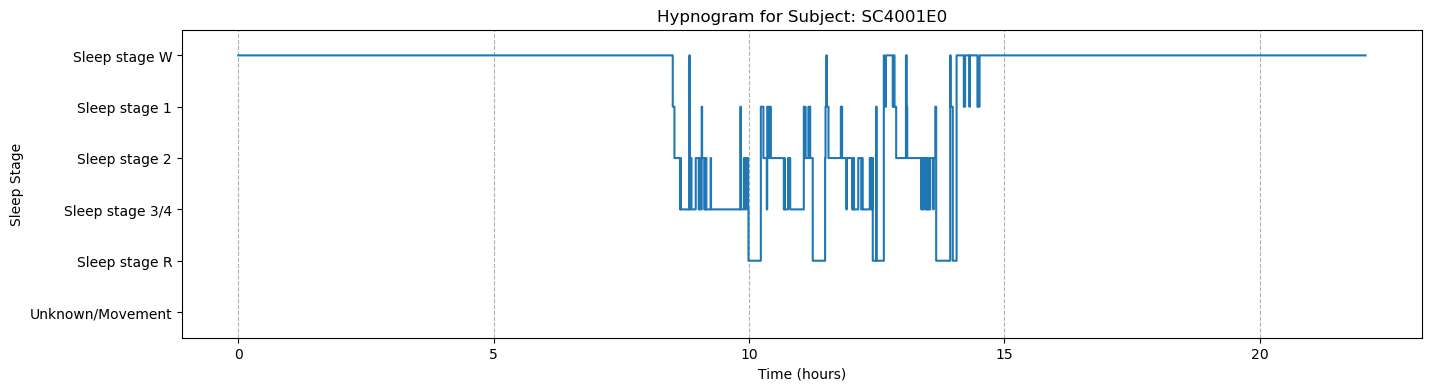

In [ ]:
if all_epochs_list:
    epochs_hypno = all_epochs_list[0]
    labels_hypno = epochs_hypno.events[:, 2]
    sfreq_hypno = epochs_hypno.info['sfreq']
    subject_id = epochs_hypno.info.get('subject_info', {}).get('id', 'Unknown')

    # Time vector for x-axis (in hours)
    n_epochs_hypno = len(labels_hypno)
    epoch_times_hours = np.arange(n_epochs_hypno) * EPOCH_DURATION / 3600.0

    # Map numerical labels back to strings for y-axis labels, ensure order
    stage_map_inv_sorted = sorted(ID_EVENT_MAPPING.items())
    stage_nums_ordered = [item[0] for item in stage_map_inv_sorted]
    stage_names_ordered = [item[1] for item in stage_map_inv_sorted]

    plt.figure(figsize=(16, 4))
    plt.plot(epoch_times_hours, labels_hypno, drawstyle='steps-post')
    plt.yticks(stage_nums_ordered, stage_names_ordered)
    plt.xlabel('Time (hours)')
    plt.ylabel('Sleep Stage')
    plt.title(f'Hypnogram for Subject: {subject_id}')
    plt.ylim(min(stage_nums_ordered) - 0.5, max(stage_nums_ordered) + 0.5)
    plt.grid(True, axis='x', linestyle='--')
    plt.gca().invert_yaxis()
    plt.show()

else:
    print("No epochs data available for hypnogram.")